# Libraries and Data

In [1]:
# # Mount Drive to access files
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# # Path to the folder
# %cd /content/drive/MyDrive/Python - Time Series Forecasting/Time Series Analysis/Exponential Smoothing and Holt Winters

In [137]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [138]:
# Loading the Data of weekly customer complaints
# and set the date as the index
df = pd.read_csv("data.csv", index_col = "Date", parse_dates = True)

df['Close'].resample('W').mean()
df.index.rename("week",inplace=True)
df.head()

,Open,High,Low,Close
week,,,,
2004-10-18,482.58,482.58,473.51,478.04
2004-10-19,476.23,480.76,474.41,475.32
2004-10-20,477.14,478.95,468.06,468.06
2004-10-21,468.06,471.69,462.62,468.06
2004-10-24,472.60,476.23,457.18,467.16


In [139]:
# Display information about the DataFrame, including data types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3834 entries, 2004-10-18 to 2024-11-20
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3834 non-null   float64
 1   High    3834 non-null   float64
 2   Low     3834 non-null   float64
 3   Close   3834 non-null   float64
dtypes: float64(4)
memory usage: 149.8 KB


# Data Pre-processing

In [141]:
# df.asfreq("W-Mon") - convert the time series data to a specified frequency, in this case, weekly data with Monday as the anchor day.
# Setting freq to W implies that the week starts on a Sunday
df = df.asfreq("W-Mon")
df.index

DatetimeIndex(['2004-10-18', '2004-10-25', '2004-11-01', '2004-11-08',
               '2004-11-15', '2004-11-22', '2004-11-29', '2004-12-06',
               '2004-12-13', '2004-12-20',
               ...
               '2024-09-16', '2024-09-23', '2024-09-30', '2024-10-07',
               '2024-10-14', '2024-10-21', '2024-10-28', '2024-11-04',
               '2024-11-11', '2024-11-18'],
              dtype='datetime64[ns]', name='week', length=1049, freq='W-MON')

A list of commonly used frequency aliases:

Time-based frequencies:

- 'D': Calendar day frequency
- 'B': Business day frequency
- 'W': Weekly frequency
- 'W-MON', 'W-TUE', ..., 'W-SUN': Weekly frequency (anchored on a specific day)
- 'M': Month end frequency
- 'MS': Month start frequency
- 'Q': Quarter end frequency
- 'QS': Quarter start frequency
- 'A' or 'Y': Year end frequency
- 'BA' or 'BY': Business year end frequency
- 'AS' or 'YS': Year start frequency
- 'BAS' or 'BYS': Business year start frequency


Hourly, minutely, and secondly frequencies:

- 'H': Hourly frequency
- 'T' or 'min': Minutely frequency
- 'S': Secondly frequency


You can also use multiples, like:

- '2D': Every 2 days
- '4H': Every 4 hours
- '15T' or '15min': Every 15 minutes

# Exploratory Data Analysis

In [142]:
df

,Open,High,Low,Close
week,,,,
2004-10-18,482.58,482.58,473.51,478.04
2004-10-25,466.25,478.95,458.99,471.69
2004-11-01,507.98,520.68,490.74,507.98
2004-11-08,495.28,498.00,489.84,498.00
2004-11-15,NaN,NaN,NaN,NaN
...,...,...,...,...
2024-10-21,74.30,77.50,74.30,75.50
2024-10-28,73.40,77.00,73.40,75.40
2024-11-04,77.50,80.90,76.20,78.70


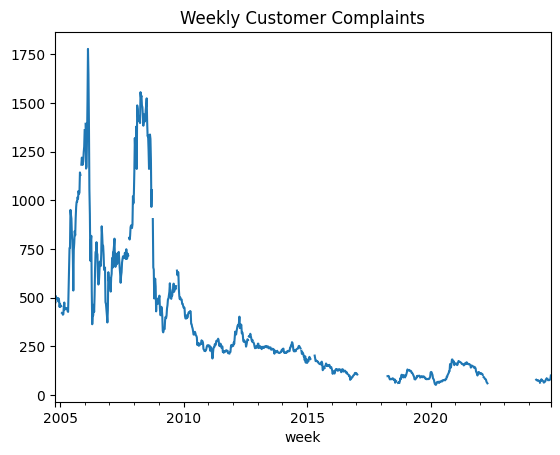

In [143]:
# Plot the weekly complaint values
df['Close'].plot(title = 'Weekly Customer Complaints')
plt.show()

C:\Users\YOUSSEF\AppData\Local\Temp\ipykernel_24964\410623732.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  month_plot(df['Close'].resample('M').mean(),


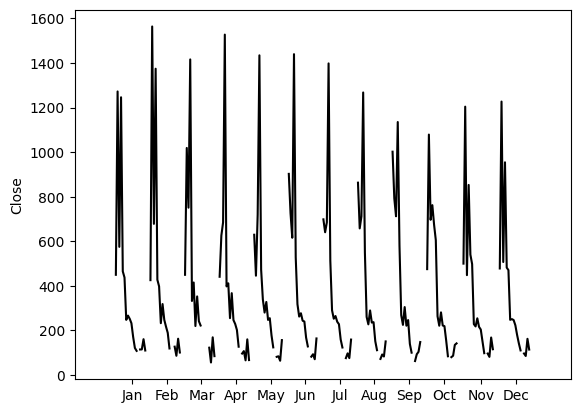

In [144]:
# month_plot() - To visualize the average value for each month across multiple years in a time series
# red lines - Represents the mean value for each month

# Plotting the monthly seasonality of the complaint values
month_plot(df['Close'].resample('M').mean(),
           ylabel = 'Close')
plt.show()

C:\Users\YOUSSEF\AppData\Local\Temp\ipykernel_24964\1383809987.py:5: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarter_plot(df['Close'].resample('Q').mean(),


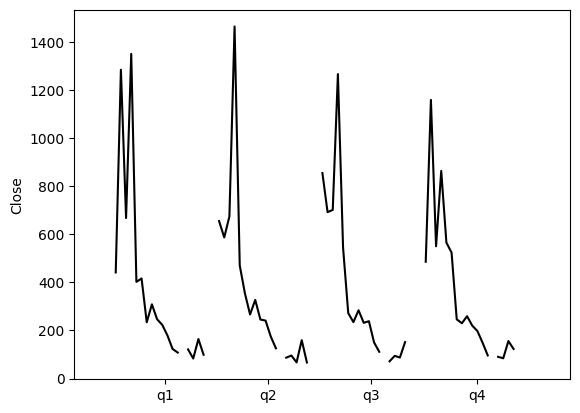

In [145]:
# quarter_plot() - To visualize seasonal patterns at a quarterly level.
# Q1 (january, february, march), Q2 (april, may, june), Q3 (july, august, september), Q4 (october, november, december)

# Plotting the quarterly seasonality of the complaint values
quarter_plot(df['Close'].resample('Q').mean(),
           ylabel = 'Close')
plt.show()

`seasonal_decompose` - To decompose a time series into its constituent parts to better understand the underlying patterns.

components

- Trend: The overall direction of the series (increasing, decreasing, or stable).
- Seasonal: Repeating patterns at fixed intervals (e.g., daily, weekly, monthly).
- Residual: The remaining variation after removing trend and seasonal components.

In [146]:
df = df.dropna(subset=['Close'])




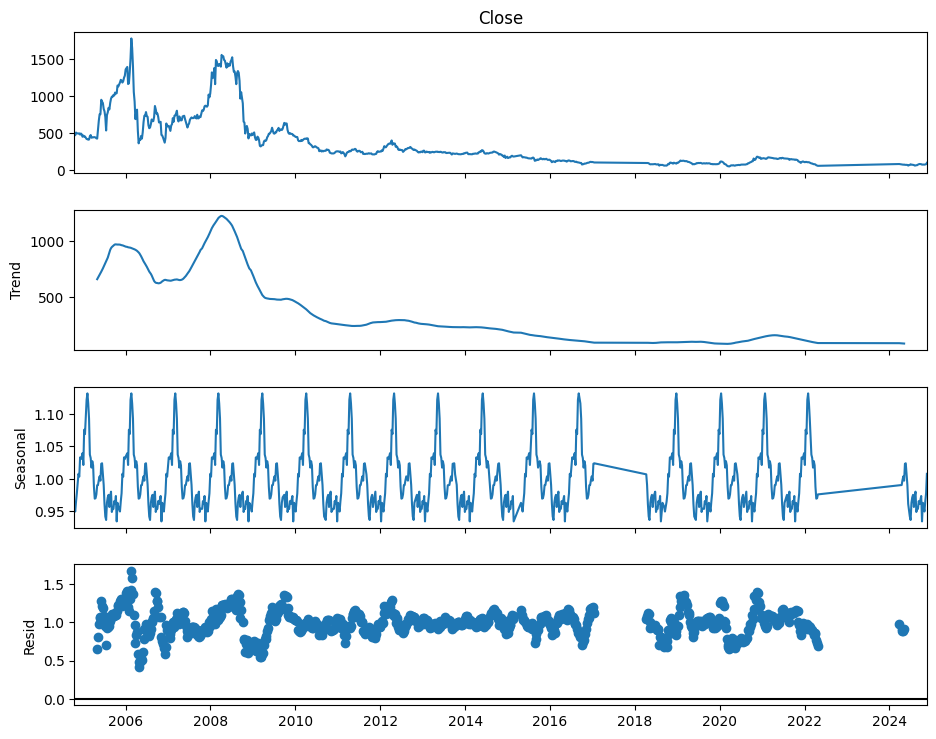

In [147]:
# Seasonal Decomposition Plots for complaint values
# Multiplicative model type, with yearly seasonality (52 weeks)
decomposition = seasonal_decompose(df['Close'],
                                   model = 'mul',
                                   period = 52)
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

Autocorrelation measures the correlation between a time series and a lagged version of itself.

Purpose: To identify patterns or repeating cycles in a time series dataset.

Interpretation:
- Values range from -1 to 1.
- 1 indicates perfect positive correlation.
- -1 indicates perfect negative correlation.
- 0 indicates no correlation.

ACF Plot:
- X-axis: Lag periods
- Y-axis: Correlation coefficient

Key Features:
- At lag 0, autocorrelation is always 1 (a series is perfectly correlated with itself).
- Significant spikes at certain lags indicate repeating patterns.


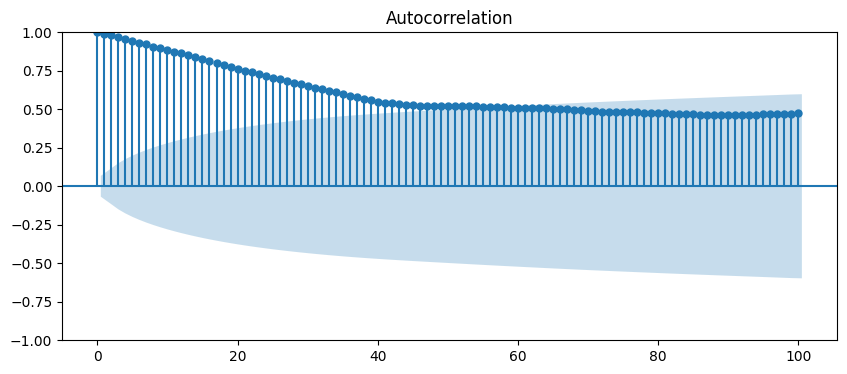

In [148]:
# Plot the autocorrelation (ACF) of complaint values
fig, ax = plt.subplots(figsize = (10,4))
plot_acf(df['Close'], lags = 100, ax = ax)
plt.show()

PACF measures the correlation between a time series and its lag, after removing the effects of all shorter lags.

Purpose: To identify the direct relationship between an observation and its lag, without intermediate effects.

Main Difference between ACF and PACF:
- ACF: Measures overall correlation at each lag, including indirect effects.
- PACF: Measures direct correlation at each lag, excluding indirect effects.

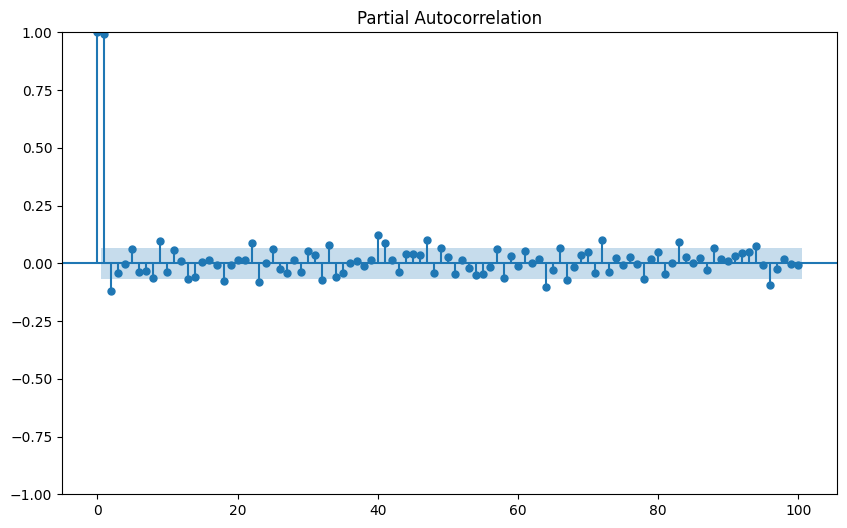

In [149]:
# Plot the partial autocorrelation (PACF) of complaint values
fig, ax = plt.subplots(figsize = (10,6))
plot_pacf(df['Close'], lags = 100, ax = ax)
plt.show()

# Training and test

# Goal : to predict the next quarter (13 weeks)

In [150]:
# Training and Test Split
# Train: all data except last n periods of the column 'complaints'
# Test: last n periods of the column 'complaints'

periods = 200
train, test = df.iloc[:-periods,0], df.iloc[-periods:, 0 ]
test.head()

week
2018-12-17     92.98
2018-12-24     88.09
2018-12-31    100.39
2019-01-07    101.18
2019-01-14    112.96
Name: Open, dtype: float64

# Simple Exponential Smoothing

Simple Exponential Smoothing assigns exponentially decreasing weights to past observations, giving more influence to recent data.

It is especially useful when there is no clear trend or seasonal pattern.

In [151]:
# Create a Simple Exponential Smoothing model using the training data.
model_simple = SimpleExpSmoothing(train).fit()
# Use the fitted model to forecast future values.
# The forecast is made for the same length as the 'test' data set.
predictions_simple = model_simple.forecast(len(test))

c:\Users\YOUSSEF\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\YOUSSEF\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\YOUSSEF\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


637    96.705622
638    96.705622
639    96.705622
640    96.705622
641    96.705622
dtype: float64
week
2018-12-17    96.705622
2018-12-24    96.705622
2018-12-31    96.705622
2019-01-07    96.705622
2019-01-14    96.705622
dtype: float64


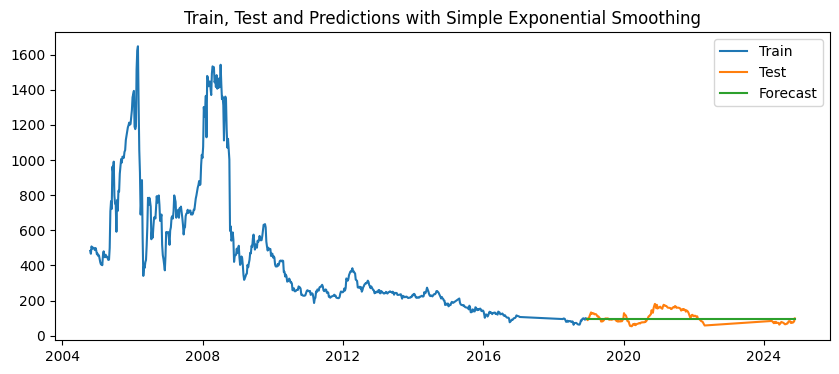

In [152]:
print(predictions_simple[:5])         

predictions_simple.index=test.index
print(predictions_simple[:5])          


plt.figure(figsize=(10, 4))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(predictions_simple, label='Forecast')
plt.title("Train, Test and Predictions with Simple Exponential Smoothing")
plt.legend()
plt.show()

# Double Exponential Smoothing

Double Exponential Smoothing (DES), also known as Holt’s Linear Trend Model, is used when the time series data exhibits a trend.

Unlike Simple Exponential Smoothing, which is suitable for data without trends or seasonality, DES can account for both the level and the trend in the data

Key Features:
- Trend Handling -  making it suitable for time series data that show a consistent upward or downward trend over time.
- Components - DES involves two components: the level (smoothed value) and the trend.

In [153]:
# Double Exponential Smoothing Model
# Initialize and fit an Exponential Smoothing model to the training data
# Use a multiplicative trend component ('mul') and no seasonal component (seasonal=None)

#El model el mafroud yb2a esmo Holt Winters bas el library msamyaah exponential smoothing

model_double = ExponentialSmoothing(train,
                                    trend = 'mul',
                                    seasonal = None).fit()

c:\Users\YOUSSEF\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [154]:
# Use the fitted Double Exponential Smoothing model to forecast future values.
# The forecast is made for the same length as the 'test' data set.
predictions_double = model_double.forecast(len(test))
predictions_double

c:\Users\YOUSSEF\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\YOUSSEF\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


637    96.562373
638    96.420071
639    96.277979
640    96.136096
641    95.994423
         ...    
832    72.429224
833    72.322487
834    72.215907
835    72.109484
836    72.003218
Length: 200, dtype: float64

637    96.562373
638    96.420071
639    96.277979
640    96.136096
641    95.994423
dtype: float64
week
2018-12-17    96.562373
2018-12-24    96.420071
2018-12-31    96.277979
2019-01-07    96.136096
2019-01-14    95.994423
dtype: float64


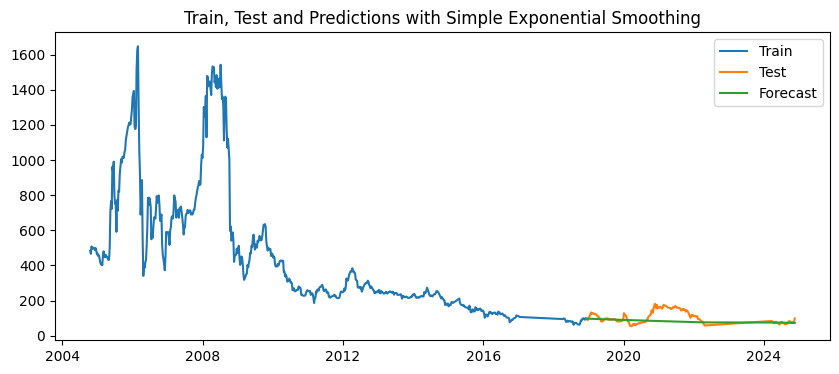

In [155]:
print(predictions_double[:5])         

predictions_double.index=test.index
print(predictions_double[:5])          


plt.figure(figsize=(10, 4))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(predictions_double, label='Forecast')
plt.title("Train, Test and Predictions with Simple Exponential Smoothing")
plt.legend()
plt.show()

# Triple Exponential Smoothing (Holt-Winters method)

Triple Exponential Smoothing, also known as Holt-Winters Exponential Smoothing, extends Double Exponential Smoothing by adding a seasonal component to handle data with seasonal patterns in addition to trends.

Key Features:
- Seasonality Handling - Triple Exponential Smoothing accommodates time series data with seasonal patterns, which can be daily, weekly, monthly, quarterly, or annual.
- Components - It involves three components: level (smoothed value), trend, and seasonal.

In [156]:
# Triple Exponential Smoothing Model
# Initialize and fit a Triple Exponential Smoothing (Holt-Winters) model to the training data
# Use an additive trend component ('add'), a multiplicative seasonal component ('mul'),
# and specify the seasonal period length as 52 (weekly data with yearly seasonality)

model_triple = ExponentialSmoothing(train,
                                    trend = 'mul',
                                    seasonal = "mul",
                                    seasonal_periods = 52).fit()

c:\Users\YOUSSEF\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\YOUSSEF\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [157]:
# Use the fitted Triple Exponential Smoothing model to forecast future values.
# The forecast is made for the same length as the 'test' data set.
predictions_triple = model_triple.forecast(len(test))
predictions_triple

c:\Users\YOUSSEF\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\YOUSSEF\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


637    103.116041
638    106.635476
639    109.219512
640     98.865547
641     91.589680
          ...    
832     76.840223
833     79.113541
834     83.247954
835     86.559947
836     88.076261
Length: 200, dtype: float64

637    103.116041
638    106.635476
639    109.219512
640     98.865547
641     91.589680
dtype: float64
week
2018-12-17    103.116041
2018-12-24    106.635476
2018-12-31    109.219512
2019-01-07     98.865547
2019-01-14     91.589680
dtype: float64


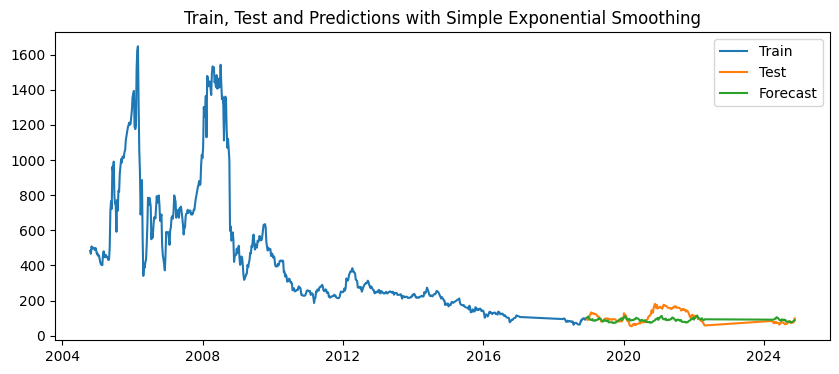

In [158]:
print(predictions_triple[:5])         

predictions_triple.index=test.index
print(predictions_triple[:5])          


plt.figure(figsize=(10, 4))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(predictions_triple, label='Forecast')
plt.title("Train, Test and Predictions with Simple Exponential Smoothing")
plt.legend()
plt.show()

- `MAE` - the average of the absolute differences between predicted and actual values.
- `RMSE` - the square root of the average of squared differences between prediction and actual observation.
It gives a relatively high weight to large errors, making it sensitive to outliers.
- `MAPE` - the size of the error in percentage terms. the average of the absolute percent errors of forecasts, which helps to understand the accuracy in terms of percentage.

In [159]:
from math import sqrt


# Calculating the MAE, RMSE, and MAPE
# between the test values and our prediction values
mae = mean_absolute_error(test, predictions_triple)
rmse = sqrt(mean_squared_error(test, predictions_triple))
mape = mean_absolute_percentage_error(test, predictions_triple)

print(f"The MAE is {mae:.2f}")
print(f"The RMSE is {rmse:.2f}")
print(f"The MAPE is {100 * mape:.2f} %")

The MAE is 30.61
The RMSE is 39.45
The MAPE is 26.22 %


week
2018-12-17    103.116041
2018-12-24    106.635476
2018-12-31    109.219512
2019-01-07     98.865547
2019-01-14     91.589680
dtype: float64
week
2018-12-17    103.116041
2018-12-24    106.635476
2018-12-31    109.219512
2019-01-07     98.865547
2019-01-14     91.589680
dtype: float64


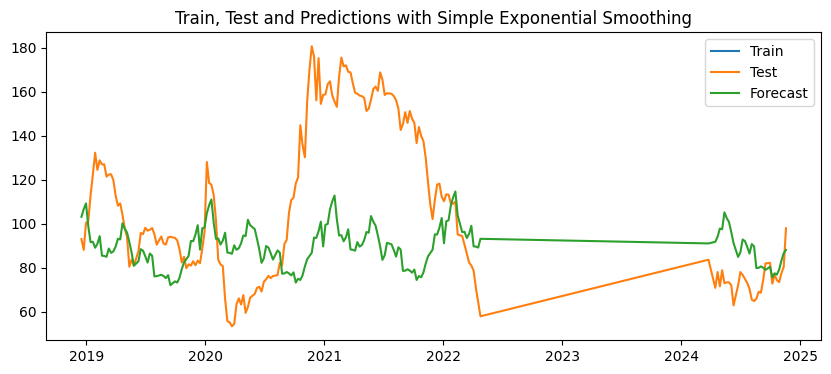

In [160]:
# Function to assess model and visualize output
def model_assessment(train, test, predictions, chart_title):
    print(predictions[:5])        

    predictions.index=test.index
    print(predictions[:5])       



    plt.figure(figsize=(10, 4))
    plt.plot(train, label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label='Forecast')
    plt.title("Train, Test and Predictions with Simple Exponential Smoothing")
    plt.legend()
    plt.show()

# Call the model_assessment function with the specified arguments
model_assessment(train['2022-06':], test, predictions_triple, "Holt-Winters")

# Predicting the future

In [161]:
# Initialize and fit a Triple Exponential Smoothing (Holt-Winters) model to the whole data
# Use an additive trend component ('add'), a multiplicative seasonal component ('mul'),
# and specify the seasonal period length as 52 (weekly data with yearly seasonality)
model = ExponentialSmoothing(df.Close,
                             trend = 'add',
                             seasonal = "mul",
                             seasonal_periods = 52).fit()

c:\Users\YOUSSEF\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\YOUSSEF\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [162]:
 # Predict the values for the next 13 weeks
forecast = model.forecast(200)
forecast

c:\Users\YOUSSEF\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\YOUSSEF\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


837     102.883086
838     109.875323
839     109.055618
840     113.338135
841     119.085760
           ...    
1032    173.046266
1033    169.306042
1034    168.799383
1035    168.120789
1036    168.451546
Length: 200, dtype: float64

837    102.883086
838    109.875323
839    109.055618
840    113.338135
841    119.085760
dtype: float64
week
2018-12-17    102.883086
2018-12-24    109.875323
2018-12-31    109.055618
2019-01-07    113.338135
2019-01-14    119.085760
dtype: float64


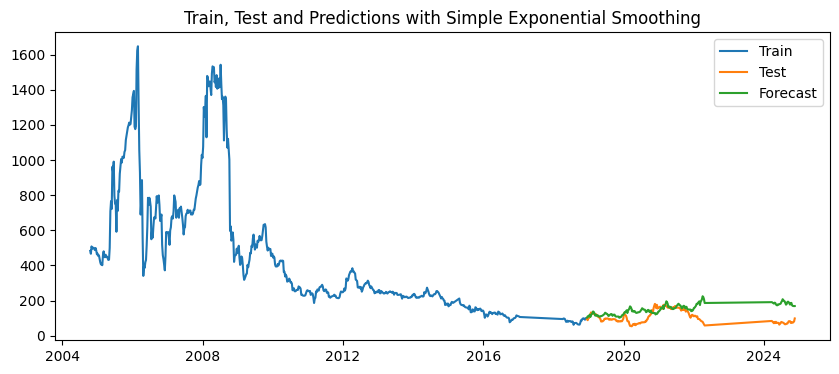

In [163]:
print(forecast[:5])         

forecast.index=test.index
print(forecast[:5])          



plt.figure(figsize=(10, 4))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='Forecast')
plt.title("Train, Test and Predictions with Simple Exponential Smoothing")
plt.legend()
plt.show()

In [164]:
# Function to plot the train and forecast values
def plot_future(y, forecast, title):
  # Set the size of the plot to 10 inches by 4 inches
  plt.figure(figsize = (10,4))
  # Plot train and forecast values
  plt.plot(df.Close, label = 'Train')
  plt.plot(forecast, label = "Forecast")
  # Add title and legend to the plot
  plt.title("Train and Forecast with Triple Exponential Smoothing")
  plt.legend()
  plt.show()

# Daily Data


In [165]:
# Loading the bitcoin data and Setting the Index
df_daily = pd.read_csv("data.csv", index_col = "Date", parse_dates = True)
df_daily.head()

,Open,High,Low,Close
Date,,,,
2004-10-18,482.58,482.58,473.51,478.04
2004-10-19,476.23,480.76,474.41,475.32
2004-10-20,477.14,478.95,468.06,468.06
2004-10-21,468.06,471.69,462.62,468.06
2004-10-24,472.60,476.23,457.18,467.16


In [166]:
# Display information about the DataFrame, including data types and non-null counts
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3834 entries, 2004-10-18 to 2024-11-20
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3834 non-null   float64
 1   High    3834 non-null   float64
 2   Low     3834 non-null   float64
 3   Close   3834 non-null   float64
dtypes: float64(4)
memory usage: 149.8 KB


In [167]:
# Convert the DataFrame to have a daily frequency.
# This ensures that the time series is indexed by every calendar day.
df_daily = df_daily.asfreq("D")
df_daily.index

DatetimeIndex(['2004-10-18', '2004-10-19', '2004-10-20', '2004-10-21',
               '2004-10-22', '2004-10-23', '2004-10-24', '2004-10-25',
               '2004-10-26', '2004-10-27',
               ...
               '2024-11-11', '2024-11-12', '2024-11-13', '2024-11-14',
               '2024-11-15', '2024-11-16', '2024-11-17', '2024-11-18',
               '2024-11-19', '2024-11-20'],
              dtype='datetime64[ns]', name='Date', length=7339, freq='D')

In [168]:
# Define the number of days to be used for the test set
periods = 200
# Split the data into training and test sets, taking the 4th column ('Close')
train, test = df_daily.iloc[:-periods,3], df_daily.iloc[-periods:, 3 ]
test.head()

Date
2024-05-05    78.8
2024-05-06    76.0
2024-05-07    76.5
2024-05-08    76.2
2024-05-09    74.6
Freq: D, Name: Close, dtype: float64

In [169]:
train = train[train > 0] 

In [170]:
# Initialize and fit a Triple Exponential Smoothing (Holt-Winters) model to the training data
# Use an additive trend component ('add'), a multiplicative seasonal component ('mul'),
# and specify the seasonal period length as 7 (daily data with weekly seasonality)

model_triple = ExponentialSmoothing(train,
                                    trend = 'mul',
                                    seasonal = "mul",
                                    seasonal_periods = 30).fit()

c:\Users\YOUSSEF\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\YOUSSEF\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [171]:
# Use the fitted Triple Exponential Smoothing model to forecast future values.
# The forecast is made for the same length as the 'test' data set. (30 days)
predictions_triple = model_triple.forecast(len(test))
predictions_triple

c:\Users\YOUSSEF\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\YOUSSEF\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


3696    73.637414
3697    73.370519
3698    73.236296
3699    72.454506
3700    72.432700
          ...    
3891    97.463671
3892    97.747971
3893    98.010887
3894    98.929986
3895    99.420033
Length: 200, dtype: float64

3696    73.637414
3697    73.370519
3698    73.236296
3699    72.454506
3700    72.432700
dtype: float64
Date
2024-05-05    73.637414
2024-05-06    73.370519
2024-05-07    73.236296
2024-05-08    72.454506
2024-05-09    72.432700
Freq: D, dtype: float64


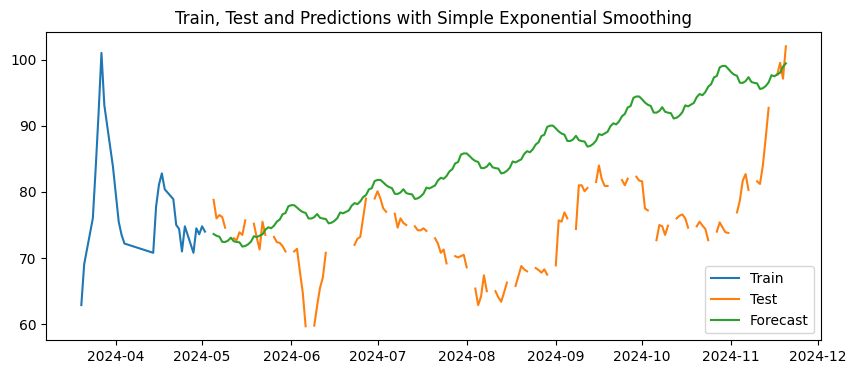

In [172]:
# Model Assessment
# Assess the performance of the model
# using test data starting from November 2023, comparing its predictions to the actual values of Bitcoin prices.
model_assessment(train['2023-11':], test, predictions_triple, "Holt-Winters vs Bitcoin")